# Heteroscedastic Gaussian Regression

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AugmentedGPLikelihoods.jl/blob/main/examples/heteroscedasticgaussian/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AugmentedGPLikelihoods.jl/dev/examples/heteroscedasticgaussian/).*

We load all the necessary packages

In [1]:
using AbstractGPs
using ApproximateGPs
using ArraysOfArrays
using AugmentedGPLikelihoods
using Distributions
using LinearAlgebra
using SplitApplyCombine

Plotting libraries

In [2]:
using Plots

We create some random data (sorted for plotting reasons)

In [3]:
N = 100
x = collect(range(-10, 10; length=N))
lik = HeteroscedasticGaussianLikelihood(InvScaledLogistic(3.0))
SplitApplyCombine.invert(x::ArrayOfSimilarArrays) = nestedview(flatview(x)')

kernel = 5.0 * with_lengthscale(SqExponentialKernel(), 2.0)
gp_f = GP(kernel)
μ₀g = -3.0
gp_g = GP(μ₀g, kernel)
f = rand(gp_f(x, 1e-6))
g = rand(gp_g(x, 1e-6))

py = lik(invert([f, g]))  # invert turns [f, g] into [[f_1, g_1], ...]
y = rand(py);

We plot the sampled data

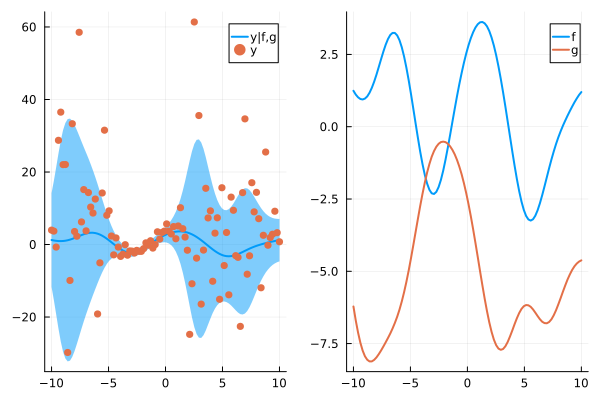

In [4]:
plt = plot(x, mean(py); ribbon=sqrt.(var(py)), label="y|f,g", lw=2.0)
scatter!(plt, x, y; msw=0.0, label="y")
plt2 = plot(x, [f, g]; label=["f" "g"], lw=2.0)
plot(plt, plt2)

## CAVI Updates
We write our CAVI algorithmm

In [5]:
function u_posterior(fz, m, S)
    return posterior(SparseVariationalApproximation(Centered(), fz, MvNormal(copy(m), S)))
end;

We can also optimize the likelihood parameter λ

In [6]:
function opt_lik(
    lik::HeteroscedasticGaussianLikelihood,
    (qf, qg)::AbstractVector{<:AbstractVector{<:Normal}},
    y::AbstractVector{<:Real},
)
    ψ = AugmentedGPLikelihoods.second_moment.(qf .- y) / 2
    c = sqrt.(AugmentedGPLikelihoods.second_moment.(qg))
    σ̃g = AugmentedGPLikelihoods.approx_expected_logistic.(-mean.(qg), c)
    λ = max(length(y) / (2 * dot(ψ, 1 .- σ̃g)), lik.invlink.λ)
    return HeteroscedasticGaussianLikelihood(InvScaledLogistic(λ))
end

function cavi!(fzs, x, y, ms, Ss, qΩ, lik; niter=10)
    K = ApproximateGPs._chol_cov(fzs[1])
    for _ in 1:niter
        posts_u = u_posterior.(fzs, ms, Ss)
        posts_fs = AbstractGPs.marginals.([p_u(x) for p_u in posts_u])
        lik = opt_lik(lik, posts_fs, y)
        aux_posterior!(qΩ, lik, y, invert(posts_fs))
        ηs, Λs = expected_auglik_potential_and_precision(lik, qΩ, y, invert(posts_fs))
        Ss .= inv.(Symmetric.(Ref(inv(K)) .+ Diagonal.(Λs)))
        ms .= Ss .* (ηs .+ Ref(K) .\ mean.(fzs))
    end
    return lik
end

cavi! (generic function with 1 method)

Now we just initialize the variational parameters

In [7]:
ms = nestedview(zeros(N, nlatent(lik)))
Ss = [Matrix{Float64}(I(N)) for _ in 1:nlatent(lik)]
qΩ = init_aux_posterior(lik, N)
fzs = [gp_f(x, 1e-8), gp_g(x, 1e-8)];
x_te = -10:0.01:10

-10.0:0.01:10.0

We run CAVI for 3-4 iterations

In [8]:
new_lik = cavi!(fzs, x, y, ms, Ss, qΩ, lik; niter=20);

And visualize the obtained variational posterior

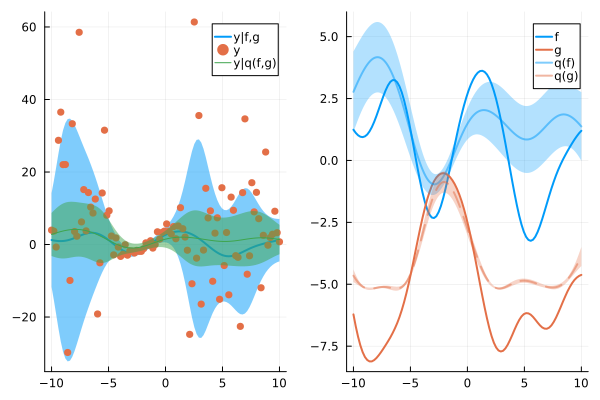

In [9]:
f_te = u_posterior(fzs[1], ms[1], Ss[1])(x_te)
g_te = u_posterior(fzs[2], ms[2], Ss[2])(x_te)
plot!(plt, x_te, mean(f_te); ribbon=sqrt.(new_lik.invlink.(mean(g_te))), label="y|q(f,g)")
plot!(plt2, f_te; color=1, linestye=:dash, alpha=0.5, label="q(f)")
plot!(plt2, g_te; color=2, linestyle=:dash, alpha=0.5, label="q(g)")
plot(plt, plt2)

## ELBO
How can one compute the Augmented ELBO?
Again AugmentedGPLikelihoods provides helper functions
to not have to compute everything yourself

In [10]:
function aug_elbo(lik, u_post, x, y)
    qf = marginals(u_post(x))
    qΩ = aux_posterior(lik, y, qf)
    return expected_logtilt(lik, qΩ, y, qf) - aux_kldivergence(lik, qΩ, y) -
           kldivergence(u_post.approx.q, u_post.approx.fz)
end

aug_elbo (generic function with 1 method)

## Gibbs Sampling
We create our Gibbs sampling algorithm (we could do something fancier with
AbstractMCMC)

In [11]:
function gibbs_sample(fzs, fs, Ω; nsamples=200)
    K = ApproximateGPs._chol_cov(fzs[1])
    Σ = [zeros(N, N) for _ in 1:nlatent(lik)]
    μ = [zeros(N) for _ in 1:nlatent(lik)]
    return map(1:nsamples) do _
        aux_sample!(Ω, lik, y, invert(fs))
        Σ .=
            inv.(
                Symmetric.(
                    Ref(inv(K)) .+ Diagonal.(auglik_precision(lik, Ω, y, invert(fs)))
                )
            )
        μ .= Σ .* (auglik_potential(lik, Ω, y, invert(fs)) .+ Ref(K) .\ mean.(fzs))
        rand!.(MvNormal.(μ, Σ), fs) # this corresponds to f -> g
        return copy(fs)
    end
end;

We initialize our random variables

In [12]:
fs_init = nestedview(randn(N, nlatent(lik)))
Ω = init_aux_variables(lik, N);

Run the sampling for default number of iterations (200)

In [13]:
fs_samples = gibbs_sample(fzs, fs_init, Ω);

And visualize the samples overlapped to the variational posterior
that we found earlier.

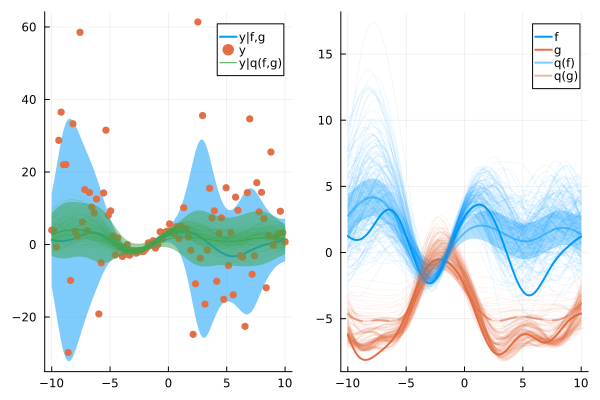

In [14]:
for fs in fs_samples
    plot!(plt, x, fs[1]; color=3, alpha=0.07, label="")
    for i in 1:nlatent(lik)
        plot!(plt2, x, fs[i]; color=i, alpha=0.07, label="")
    end
end
plt2

plot(plt, plt2)

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
Status &#96;~/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl/examples/heteroscedasticgaussian/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.21
  &#91;298c2ebc&#93; ApproximateGPs v0.4.5
  &#91;65a8f2f4&#93; ArraysOfArrays v0.6.5
  &#91;4689c64d&#93; AugmentedGPLikelihoods v0.4.18 &#96;/home/runner/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl#main&#96;
  &#91;31c24e10&#93; Distributions v0.25.109
  &#91;98b081ad&#93; Literate v2.19.0
  &#91;91a5bcdd&#93; Plots v1.40.5
  &#91;03a91e81&#93; SplitApplyCombine v1.2.3
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.10.4
Commit 48d4fd48430 &#40;2024-06-04 10:41 UTC&#41;
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux &#40;x86_64-linux-gnu&#41;
  CPU: 4 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 &#40;ORCJIT, znver3&#41;
Threads: 1 default, 0 interactive, 1 GC &#40;on 4 virtual cores&#41;
Environment:
  JULIA_PKG_SERVER_REGISTRY_PREFERENCE &#61; eager
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/7M86H/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*